In [4]:
%reload_ext autoreload
%autoreload 2

# %matplotlib widget

%matplotlib qt

# %gui qt

import time
import random
from copy import copy
from tqdm import tqdm
from pathlib import Path
import numpy as np
import numba as nb
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.width = 1000

from vrAnalysis import session
from vrAnalysis import functions
from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import fileManagement as fm
from vrAnalysis import database
from vrAnalysis import tracking

from vrAnalysis.redgui import redCellGUI as rgui

vrdb = database.vrDatabase()

In [115]:
# Immediate next steps for programming work:

# ROICaT index alignment tools
# -- include powerset based tool to determine number of ROIs successfully tracked given a start session, end session, and required include sessions 
# -------- make a list of all powersets of non-required sessions in between start and end, 
# -------- then figure out how many ROIs are tracked for each combination

In [241]:
# Database Requirements: 
# ---------------------
# GUI: db manager
# - show full database -
# - show selected entries (like for example entries with imaging but no suite2p) -
#                --> It would be sweet to make this work where there are some defaults, but then there is also a "filter command" option which you type and goes as the input to the filtering
# - click on entry and do things:
#                --> open file explorer to that session
#                --> do suite2p
#                --> do red cell management
# - update table data? 
# ---------------------
# Operational Commands: 
# - Automatically do suite2p 
# - Check if registration was done before a suite2p update
# - Find way to determine if a suite2p file was updated after the folder was made (indicating that QC was done afterwards) -- so registration should be rerun for imaging data at least
#    -- check if "iscell" is the only thing that was done after registration. In this case, just update the iscell oneData
# ---------------------
# - Add new entry GUI!!!
# ---------------------
# - Check session folders to see if new session is present that isn't registered in the database? 
# ---------------------
# vrExperimentUpdates: 
# -- if edited iscell, will need to re-register the number of ROIs per plane (in "self.values") and reprocess imaging data!
# ---------------------
# vrExperimentRegistration
# -- if error, then note there was an error and append an explanation...!!!
# ---------------------

In [2]:
mouseName = 'CR_Hippocannula6'
dateString = '2022-09-05'
sessionid = '701'
# vrExperiment registration and preprocessing 
# vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
# vrReg.processTimeline()
# vrReg.processImaging()
# vrReg.processRedCells()
# vrReg.saveParams()
# print(vrReg.sessionPath())
# del vrReg

In [19]:
# I need to remove the silly variables from CR_Hippos on D:/

In [26]:
# ROICaT Alignment Tools
# Track Red Cell Consistency across days

In [ ]:
# this is a session iterable (a list of vrExperiment objects) that I want to 
# analyze, in this case I'm ignoring mouse ATL023 and only getting sessions 
# that used an experimentID > 0. 
ises = vrdb.iterSessions(imaging=True, vrRegistration=True, mouseName=('ATL023','!='), experimentID=(0, '>'))

# then for each session, I make a `pcss` object. 
ipcss = []
for ses in tqdm(ises):
    ipcss.append(analysis.placeCellSingleSession(ses))
    ses.clearBuffer() # clearing the buffer removes data loaded in each session object which is unnecessary and usually quite large

 85%|█████████████████████████████████████████████████████████████████████▉            | 58/68 [10:17<02:21, 14.20s/it]

In [ ]:
# make sure to feed in the preloaded `ises` and `ipcss` objects. 
# cutoffs determine the reliability cutoff (see above)
# include_manual determines whether to use manually annotated cells in the red idx. 
# note: you can also request to only use the suite2p index -- see the module for details
analysis.plot_reliable_difference(ises=ises, ipcss=ipcss, cutoffs=(0.5, 0.8), include_manual=True, withSave=False, withShow=True)

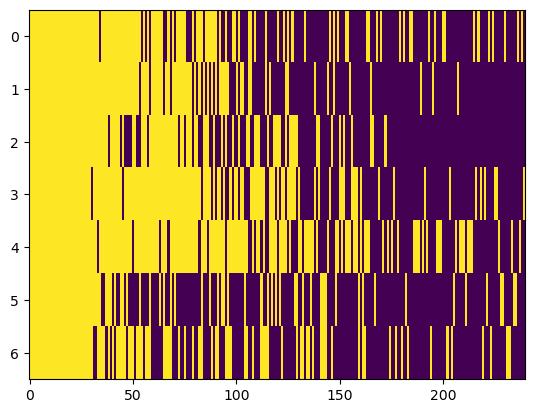

In [389]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None, use_s2p=True)
idx_has_red = idx_red[:, np.any(idx_red, axis=0)]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()

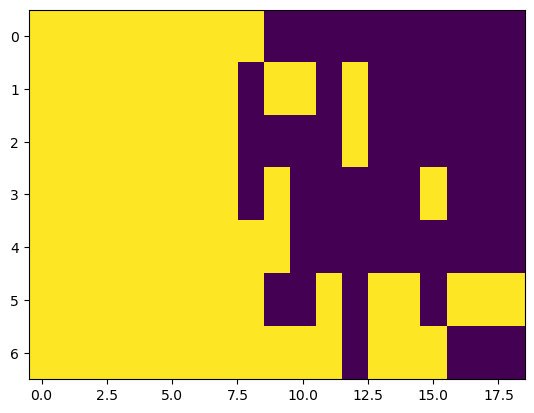

In [392]:
idx_red = track.check_red_cell_consistency(idx_ses=idx_ses, keepPlanes=None)
idx_has_red = idx_red[:, np.sum(idx_red, axis=0)>0]
idx_sort = np.argsort(-np.sum(idx_has_red,axis=0))
idx_plot = idx_has_red[:, idx_sort]
plt.close('all')
plt.imshow(idx_plot, aspect='auto', interpolation='none')
plt.show()

In [ ]:
# next step in analysis: 
# Also - using a cutoff point by the hitch in that distribution might ignore true matches that are soma-dendritic, but maybe I can use ROICaT or npix to avoid those? 

In [ ]:
# okay, looking at these clusters, it seems like there is some serious oversplitting going on in suite2p. That sucks!
# I think I should probably try to rerun some suite2p sessions....
# But for now I'll probably do a "merge" procedure... and I honestly think I'll have to overwrite or add a new "modified" suite2p folder with the stat and ops files